In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [31]:
def generate_fake_data():
    t_data = [0, 13, 20, 32, 42, 55, 65, 75, 85, 88, 95, 98, 107, 115, 120]
    V_data = [250, 255, 550, 575, 576, 800, 1050, 1250, 1750, 2000, 2550, 2750, 3000, 3500, 4000]
    return np.array(t_data), np.array(V_data)

In [32]:
def logistic_growth(t, V, c, V_max):
    return c * V * (1 - V / V_max)

In [33]:
def gompertz_growth(t, V, c, V_max):
    return c * V * np.log(V_max / V)    

In [34]:
def von_bertalanffy_growth(t, V, c, d):
    return c * V**(2/3) - d * V

In [35]:
def Hean_method(model_growth, t, V0, c, V_max, dt):
    V = [V0]
    for i in range(1, len(t)):
        t_current = t[i-1]
        V_current = V[-1]
        
        y1 = model_growth(t_current, V_current, c, V_max)
        
        
        V_euler = V_current + dt * y1
        y2 = model_growth(t_current + dt, V_euler, c, V_max)
        
        V_new = V_current + dt * 0.5 * (y1 + y2)
        V.append(V_new)
    
    return np.array(V)

In [36]:
import numpy as np

def Runga_method(model_growth, t, V0, c, V_max, dt):

    V = [V0]  
    for i in range(1, len(t)):
        t_current = t[i - 1]
        V_current = V[-1]

        
        y1 = dt * model_growth(t_current, V_current, c, V_max)
        y2 = dt * model_growth(t_current + dt / 2, V_current + y1 / 2, c, V_max)
        y3 = dt * model_growth(t_current + dt / 2, V_current + y2 / 2, c, V_max)
        y4 = dt * model_growth(t_current + dt, V_current + y3, c, V_max)

       
        V_new = V_current + (y1 + 2 * y2 + 2 * y3 + y4) / 6
        V.append(V_new)
    
    return np.array(V)


In [37]:
def gompertz_hean(t, V0, c, V_max, dt):
    return Hean_method(gompertz_growth, t, V0, c, V_max, dt)

In [38]:
def logistic_hean(t, V0, c, V_max, dt):
    return Hean_method(logistic_growth, t, V0, c, V_max, dt)

In [39]:
def von_bertalanffy_hean(t, V0, c, d, dt):
    return Hean_method(von_bertalanffy_growth, t, V0, c, d, dt)

In [40]:
def gompertz_Runga(t, V0, c, V_max, dt):
    return Runga_method(gompertz_growth, t, V0, c, V_max, dt)

In [41]:
def logistic_Runga(t, V0, c, V_max, dt):
    return Runga_method(logistic_growth, t, V0, c, V_max, dt)

In [42]:
def von_bertalanffy_runga(t, V0, c, d, dt):
    return Runga_method(von_bertalanffy_growth, t, V0, c, d, dt)

In [43]:
def gompertz_wrapper(t, c, V_max):
    """Wrapper om Gompertz-growth werkend te maken met curve_fit."""
    V0 = 250  
    dt = t[1] - t[0]  
    V = [V0]
    for i in range(1, len(t)):
        V_new = V[-1] + dt * gompertz_growth(t[i], V[-1], c, V_max)
        V.append(V_new)
    return np.array(V)


In [44]:
def logistic_wrapper(t, c, V_max):
    """Wrapper om Logistic-growth werkend te maken met curve_fit."""
    V0 = 250  
    dt = t[1] - t[0]  
    V = [V0]
    for i in range(1, len(t)):
        V_new = V[-1] + dt * logistic_growth(t[i], V[-1], c, V_max)
        V.append(V_new)
    return np.array(V)

In [45]:
def von_bertalanffy_wrapper(t, c, d):
    """Wrapper om Von Bertalanffy-groei werkend te maken met curve_fit."""
    V0 = 250  # Initieel volume
    dt = t[1] - t[0]  # Tijdstap
    V = [V0]
    for i in range(1, len(t)):
        V_new = V[-1] + dt * von_bertalanffy_growth(t[i], V[-1], c, d)
        V.append(V_new)
    return np.array(V)

In [46]:
def fit_model(model_wrapper, t_data, V_data, p0):
    """
    Past het model aan de data aan en retourneert de optimale parameters.
    """
    popt, pcov = curve_fit(model_wrapper, t_data, V_data, p0=p0)
    return popt

/tmp/ipykernel_539899/4263784990.py:2: RuntimeWarning: invalid value encountered in log
  return c * V * np.log(V_max / V)


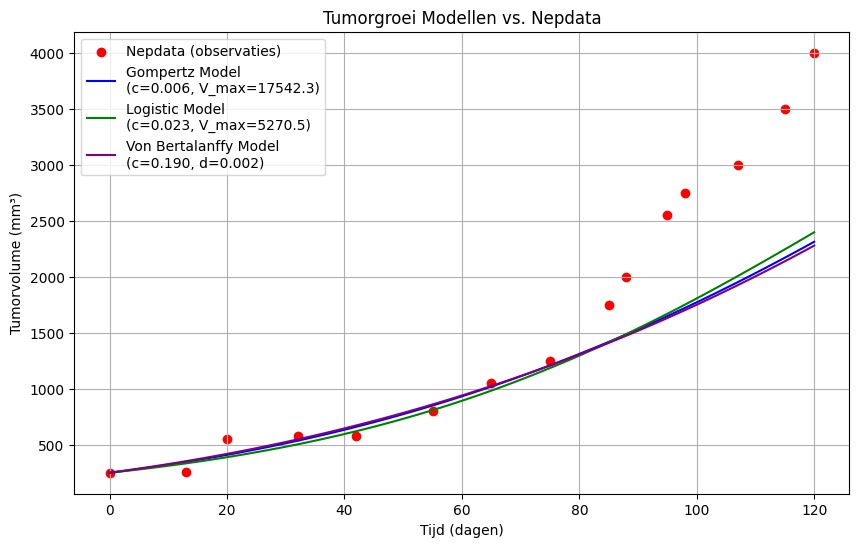

In [47]:
if __name__ == "__main__":
    
    t_data, V_data = generate_fake_data()
    tijd = np.linspace(0, 120, 100)

    
    initial_params = [0.1, 4000]  
    initial_params_von_bertalanffy = [0.1, 0.01]  
    
    params_gompertz = fit_model(gompertz_wrapper, t_data, V_data, p0=initial_params)
    params_logistic = fit_model(logistic_wrapper, t_data, V_data, p0=initial_params)
    params_von_bertalanffy = fit_model(von_bertalanffy_wrapper, t_data, V_data, p0=initial_params_von_bertalanffy)

    
    dt = tijd[1] - tijd[0]  
    V_sim_gompertz = gompertz_hean(tijd, 250, *params_gompertz, dt)
    V_sim_logistic = logistic_hean(tijd, 250, *params_logistic, dt)
    V_sim_von_bertalanffy = von_bertalanffy_hean(tijd, 250, *params_von_bertalanffy, dt)

   
    plt.figure(figsize=(10, 6))

    
    plt.scatter(t_data, V_data, color="red", label="Nepdata (observaties)")

    
    plt.plot(tijd, V_sim_gompertz, label=f"Gompertz Model\n(c={params_gompertz[0]:.3f}, V_max={params_gompertz[1]:.1f})", color="blue")

   
    plt.plot(tijd, V_sim_logistic, label=f"Logistic Model\n(c={params_logistic[0]:.3f}, V_max={params_logistic[1]:.1f})", color="green")

    plt.plot(tijd, V_sim_von_bertalanffy, 
             label=f"Von Bertalanffy Model\n(c={params_von_bertalanffy[0]:.3f}, d={params_von_bertalanffy[1]:.3f})", 
             color="purple")

    plt.title("Tumorgroei Modellen vs. Nepdata")
    plt.xlabel("Tijd (dagen)")
    plt.ylabel("Tumorvolume (mm³)")
    plt.legend()
    plt.grid(True)
    plt.show()

/tmp/ipykernel_539899/4263784990.py:2: RuntimeWarning: invalid value encountered in log
  return c * V * np.log(V_max / V)


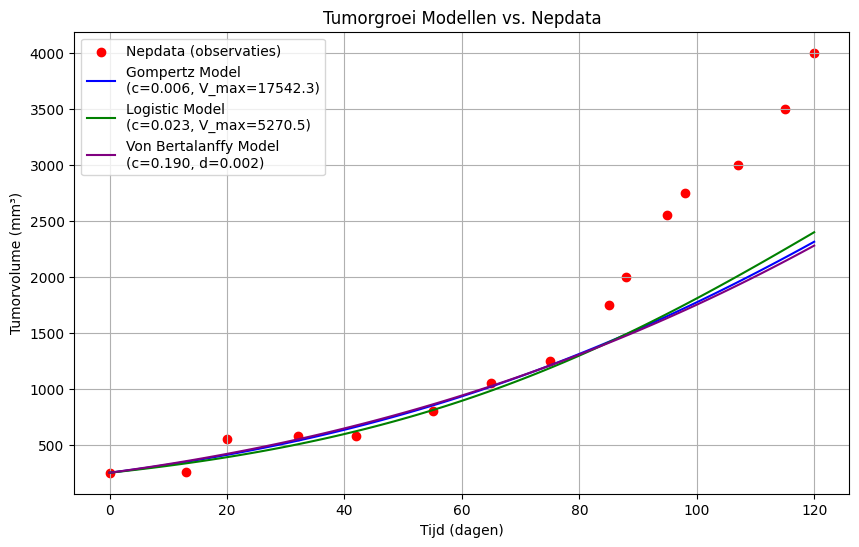

In [48]:
if __name__ == "__main__":
    
    t_data, V_data = generate_fake_data()
    tijd = np.linspace(0, 120, 100)

    
    initial_params = [0.1, 4000]  
    initial_params_von_bertalanffy = [0.1, 0.01]  

    
    params_gompertz = fit_model(gompertz_wrapper, t_data, V_data, p0=initial_params)
    params_logistic = fit_model(logistic_wrapper, t_data, V_data, p0=initial_params)
    params_von_bertalanffy = fit_model(von_bertalanffy_wrapper, t_data, V_data, p0=initial_params_von_bertalanffy)

    
    dt = tijd[1] - tijd[0]  
    V_sim_gompertz = gompertz_Runga(tijd, 250, *params_gompertz, dt)
    V_sim_logistic = logistic_Runga(tijd, 250, *params_logistic, dt)
    V_sim_von_bertalanffy = von_bertalanffy_runga(tijd, 250, *params_von_bertalanffy, dt)

     
    
   
    plt.figure(figsize=(10, 6))

    
    plt.scatter(t_data, V_data, color="red", label="Nepdata (observaties)")

    
    plt.plot(tijd, V_sim_gompertz, label=f"Gompertz Model\n(c={params_gompertz[0]:.3f}, V_max={params_gompertz[1]:.1f})", color="blue")

   
    plt.plot(tijd, V_sim_logistic, label=f"Logistic Model\n(c={params_logistic[0]:.3f}, V_max={params_logistic[1]:.1f})", color="green")

    plt.plot(tijd, V_sim_von_bertalanffy, 
             label=f"Von Bertalanffy Model\n(c={params_von_bertalanffy[0]:.3f}, d={params_von_bertalanffy[1]:.3f})", 
             color="purple")

    plt.title("Tumorgroei Modellen vs. Nepdata")
    plt.xlabel("Tijd (dagen)")
    plt.ylabel("Tumorvolume (mm³)")
    plt.legend()
    plt.grid(True)
    plt.show()